# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

Video N°143: Downloading and preparing data for our first transfer learning model

## Download and becoming one with the data

In [1]:
from utils.data_acquisition.data_downloader import download_data

In [2]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/datasets/dansbecker/food-101
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
file_path = "10_food_classes_10_percent.zip"
download_data(url=url, file_path=file_path, extract=True)

The file 10_food_classes_10_percent.zip already exists.
Extracting 10_food_classes_10_percent.zip as ZIP...
10_food_classes_10_percent.zip has been extracted to current directory.


In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches. 

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

flow_from_dir_args = {
    "target_size": (224, 224),
    "color_mode": "rgb",
    "batch_size": 32,
    "class_mode": "categorical",
    "shuffle": True
}

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir, **flow_from_dir_args)

print("Testing images:")
test_data = test_datagen.flow_from_directory(directory=test_dir, **flow_from_dir_args)

2024-03-24 10:54:46.971575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Video N°144: Introducing Callbacks in TensorFlow and making a callback to track our models

## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the modt popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
from utils.training_utilities.model_callbacks import create_tensorboard_callback

🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option

Video N°145: Exploring the TensorFlow Hub website for pretrained models

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.
Now we're going to do a similar process, except the majority of our model's layers are going to come frome TensorFlow Hub.
We can access pretrained models on: https://tfhub.dev/
Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

Video N°146: Building and compiling a TensorFlow feature extraction model

In [6]:
# Let's compare the following two models
resnet_ulr = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_ulr = "https://rfhub.dev/tensorflow/efficientnet/b0/feature_vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from a URL
from utils.training_utilities.transfer_learning import build_complete_model_from_url

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = build_complete_model_from_url(model_url=resnet_ulr,
                                             num_classes=train_data_10_percent.num_classes,
                                             input_shape=(224, 224, 3))

2024-03-24 10:54:48.834165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-24 10:54:48.849608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-24 10:54:48.849805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-24 10:54:48.850128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
train_data_10_percent.num_classes

10

In [12]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

Video N°147: Blowing our previous models out of the water with transfer learning

In [14]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorboard_hub/resnet50V2/20240324-105516
Epoch 1/5


2024-03-24 10:55:19.342788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-03-24 10:55:19.427884: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-24 10:55:22.213884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-24 10:55:22.228536: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2568321b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 10:55:22.228561: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-03-24 10:55:22.232325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-24 10:55:22.29586

24/24 [==============================] - 21s 637ms/step - loss: 1.9305 - accuracy: 0.3693 - val_loss: 1.1892 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 12s 505ms/step - loss: 0.9023 - accuracy: 0.7293 - val_loss: 0.8270 - val_accuracy: 0.7488
Epoch 3/5
24/24 [==============================] - 11s 487ms/step - loss: 0.6154 - accuracy: 0.8173 - val_loss: 0.7399 - val_accuracy: 0.7712
Epoch 4/5
24/24 [==============================] - 11s 490ms/step - loss: 0.4766 - accuracy: 0.8747 - val_loss: 0.7113 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 12s 503ms/step - loss: 0.3808 - accuracy: 0.9120 - val_loss: 0.6654 - val_accuracy: 0.7820


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

Video N°148: Plotting the loss curves of our ResNet feature extraction model

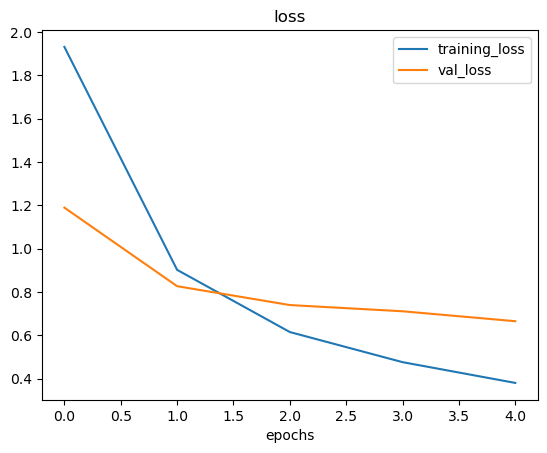

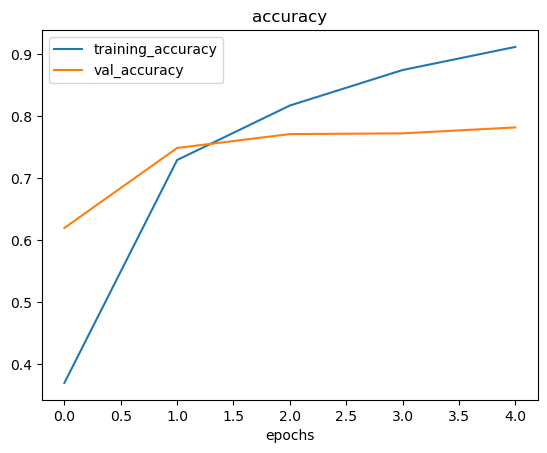

In [18]:
# Let's create a function to plot our loss curves...
from utils.data_visualization.model_learning_curves import plot_loss_curves
plot_loss_curves(history=resnet_history)

Video N°149: Building and training a pre-trained EfficientNet model on our data

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model